# Continuous Linear Optimal Transport Transform (CLOT)

This tutorial will demonstrate: how to use the forward and inverse operations of the CLOT in the the *PyTransKit* package.

## Class:: CLOT

    Continuous Linear Optimal Transport Transform.

    Parameters
    ----------
    lr : float (default=0.01)
        Learning rate.
    momentum : float (default=0.)
        Nesterov accelerated gradient descent momentum.
    decay : float (default=0.)
        Learning rate decay over each update.
    max_iter : int (default=300)
        Maximum number of iterations.
    tol : float (default=0.001)
        Stop iterating when change in cost function is below this threshold.
    verbose : int (default=1)
        Verbosity during optimization. 0=no output, 1=print cost,
        2=print all metrics.

    Attributes
    -----------
    displacements_ : array, shape (2, height, width)
        Displacements u. First index denotes direction: displacements_[0] is
        y-displacements, and displacements_[1] is x-displacements.
    transport_map_ : array, shape (2, height, width)
        Transport map f. First index denotes direction: transport_map_[0] is
        y-map, and transport_map_[1] is x-map.
    displacements_initial_ : array, shape (2, height, width)
        Initial displacements computed using the method by Haker et al.
    transport_map_initial_ : array, shape (2, height, width)
        Initial transport map computed using the method by Haker et al.
    cost_ : list of float
        Value of cost function at each iteration.
    curl_ : list of float
        Curl at each iteration.

    References
    ----------
    [A continuous linear optimal transport approach for pattern analysis in
    image datasets]
    (https://www.sciencedirect.com/science/article/pii/S0031320315003507)
    [Optimal mass transport for registration and warping]
    (https://link.springer.com/article/10.1023/B:VISI.0000036836.66311.97)

Functions:
--------------    
1. Forward transform:
        lot = forward(sig0, sig1)
        
        Inputs:
        ----------------
        sig0 : array, shape (height, width)
            Reference image.
        sig1 : array, shape (height, width)
            Signal to transform.
            
        Outputs:
        ----------------
        lot : array, shape (2, height, width)
            LOT transform of input image sig1. First index denotes direction:
            lot[0] is y-LOT, and lot[1] is x-LOT.

2. Apply forward transport map:
        sig0_recon = apply_forward_map(transport_map, sig1)
        
        Inputs:
        ----------------
        transport_map : array, shape (2, height, width)
            Forward transport map.
        sig1 : array, shape (height, width)
            Signal to transform.
            
        Outputs:
        ----------------
        sig0_recon : array, shape (height, width)
            Reconstructed reference signal sig0.
        
3. Apply inverse transport map:
        sig1_recon = inverse(transport_map, sig0)
        
        Inputs:
        ----------------
        transport_map : array, shape (2, height, width)
            Forward transport map. Inverse is computed in this function.
        sig0 : array, shape (height, width)
            Reference signal.
    
        Outputs:
        ----------------
        sig1_recon : array, shape (height, width)
            Reconstructed signal sig1.
    

## Definition
The Continuous Linear Optimal Transport (CLOT) transform $\widehat s$ of a density function $s(\mathbf x)$ is defined as the optimal transport map from a reference density $s_0(\mathbf x)$ to $s(\mathbf x)$. Specifically, let $s_0(\mathbf x), s(\mathbf x)$ be positive functions defined on domains $\Omega_{s_0}, \Omega_{s}\subseteq \mathbb R^d$ respectively and such that $$\int_{\Omega_{s_0}}s_0(\mathbf x) d\mathbf x = \int_{\Omega_{s}}s(\mathbf x) d\mathbf x =1 \quad \text{(normalized)}.$$<br>

Assuming that the density functions $s_0, s$ have finite second moments, there is an unique solution  
 to the Monge optimal transport problem:
\begin{align} \label{Monge}
&\text{min Monge }(T)=\int_{R^d}\big|x-T(x)|^2s_0(x)dx, \qquad (1)\\
 &\text{s.t.}\quad  \int_{B}s(\mathbf y)d\mathbf y= \int_{T^{-1}(B)} s_0(\mathbf x) d\mathbf x, \quad \text{for all open} \ B\subseteq \mathbb R^d.  \qquad (2) \label{mass-preserving}
\end{align}
Any map $T$ satisfying constraint in (2) is called a transport (mass-preserving) map between $s_0$ and $s$. In particular, when $T$ is bijective and continuously differentiable, the mass-preserving constraint in (2) becomes 
\begin{equation} \label{MassCons}
s_0(x)= |\det \big(\nabla T(x)\big)|s\big(T(x)\big).
\end{equation}

The minimizer to the above Monge problem is called an optimal transport map. Given a fixed reference density $s_0$, the LOT transform $\widehat s$ of a density function $s$ is defined  to the unique optimal transport map from $s_0$ to $s$. 
Moreover Brenier [1] shows that any optimal transport map can be written as the gradient of a convex function, i.e., $\widehat s = \nabla \phi$ where $\phi$ is a convex function. Following the generic approach described in [2], Kolouri et al. [3] employed an iterative algorithm minimizing (1) with constraint (2) via the gradient descent idea.

### References
[1] Y. Brenier.   Polar factorization and monotone rearrangement of vector-valuedfunctions.Commun. Pure Appl. Math., 44(4):375–417, 1991.1 <br>
[2] S. Haker, L. Zhu, A. Tannenbaum, and S. Angenent.  Optimal mass transport forregistration and warping.Int. J. Comput. Vis., 60(4):225–240, 2004.<br>
[3] S. Kolouri, A. Tosun, J. Ozolek, and G. Rohde. A continuous linear optimal trans-port approach for pattern analysis in image datasets.Pattern Recognit., 51:453–462, 2016.

## CLOT Demo
The examples will cover the following operations:
* Forward operation of the CLOT
* Apply forward map to transport $I_1$ to $I_0$
* Apply inverse map to reconstruct $I_1$ from $I_0$

## Forward CLOT

### Import necessary python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Read and normalize two images $I_0$ and $I_1$.

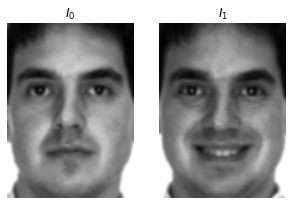

In [2]:
import matplotlib.image as mpimg
import sys
sys.path.append('../')
from pytranskit.optrans.utils import signal_to_pdf

I0 = mpimg.imread('images/I0.bmp')
I1 = mpimg.imread('images/I1.bmp')

# Convert images to PDFs
img0 = signal_to_pdf(I0, sigma=1., total=100.)
img1 = signal_to_pdf(I1, sigma=1., total=100.)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,10))
ax[0].imshow(img0,cmap='gray')
ax[1].imshow(img1,cmap='gray')
ax[0].set_title('$I_0$')
ax[1].set_title('$I_1$')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### Compute CLOT and apply forward map

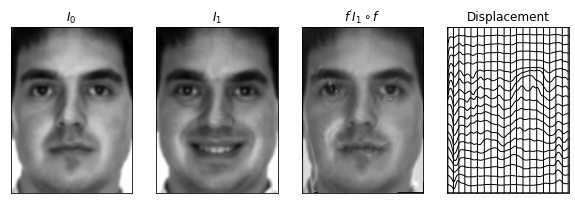

In [7]:
from pytranskit.optrans.continuous.clot import CLOT
from pytranskit.optrans.utils import plot_displacements2d

clot = CLOT(max_iter=500, lr=1e-6, tol=1e-4,verbose=0)

# calculate CLOT
lot = clot.forward(img0, img1)

# transport map and displacement map from I1 to I0
tmap10 = clot.transport_map_
disp = clot.displacements_

# apply forward map to transport I1 to I0
img0_recon = clot.apply_forward_map(tmap10, img1)

fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10,20))
ax[0].imshow(img0, cmap='gray')
ax[0].set_title('$I_0$')

ax[1].imshow(img1, cmap='gray')
ax[1].set_title('$I_1$')

ax[2].imshow(img0_recon, cmap='gray')
ax[2].set_title('$f^{\'}I_1\circ f$')

plot_displacements2d(disp, ax=ax[3], count=20)
ax[3].set_title('Displacement')

plt.show()

## Inverse CLOT
Apply inverse map on $I_0$ to reconstruct $I_1$

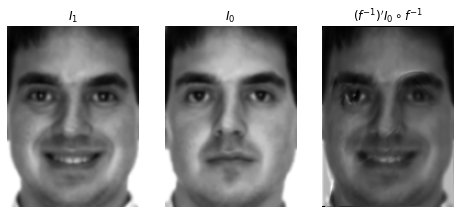

In [4]:
img1_recon = clot.apply_inverse_map(tmap10, img0)

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(8,15))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('$I_1$')

ax[1].imshow(img0, cmap='gray')
ax[1].set_title('$I_0$')

ax[2].imshow(img1_recon, cmap='gray')
ax[2].set_title('$(f^{-1})\'I_0\circ f^{-1}$')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.show()

## Geodesic
Show points on the geodesic between $I_0$ and $I_1$

<function matplotlib.pyplot.show(*args, **kw)>

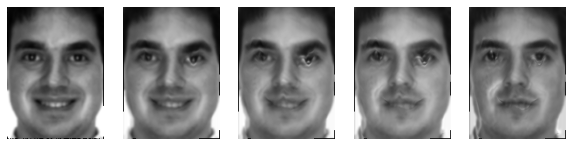

In [5]:
lot11 = clot.forward(img1, img1)
tmap11 = clot.transport_map_

alpha = np.linspace(0,1,5)
img_recon = []
fig, ax = plt.subplots(1, len(alpha), sharex=True, sharey=True, figsize=(10,5*len(alpha)))
for i in range(len(alpha)):
    tmap = alpha[i]*tmap10 + (1-alpha[i])*tmap11
    img_recon.append(clot.apply_forward_map(tmap, img1))
    ax[i].imshow(img_recon[i],cmap='gray')
    ax[i].axis('off')
plt.show